## Replication of results from paper: "Predicting yeast synthetic lethal genetic interactions using protein domains" 

- Authors: Bo Li, Feng Luo,School of Computing,Clemson University,Clemson, SC, USA
- e-mail: bol, luofeng@clemson.edu
- year:2009

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
import seaborn as sns
import matplotlib.cm as cm
import scipy as scipy
import random

### Importing datasets 

#### Link to the github repo where the datasets to be downloaded:
[DOWNLOAD THE DATASETS HERE](https://github.com/leilaicruz/machine-learning-for-yeast/tree/dev_Leila/datasets-for-learning)

In [2]:
import os
script_dir = os.path.dirname('__file__') #<-- absolute dir the script is in
rel_path_SL = "datasets/data-synthetic-lethals.xlsx"
rel_path_nSL="datasets/data-positive-genetic.xlsx"
rel_path_domains="datasets/proteins-domains-from-Pfam.xlsx"

abs_file_path_SL = os.path.join(script_dir, rel_path_SL)
abs_file_path_nSL = os.path.join(script_dir, rel_path_nSL)
abs_file_path_domains = os.path.join(script_dir, rel_path_domains)

# os.chdir('mini_book/docs/') #<-- for binder os.chdir('../')
# os.chdir('../')
my_path_sl= abs_file_path_SL
my_path_non_sl=abs_file_path_nSL
my_path_domains=abs_file_path_domains

data_sl=pd.read_excel(my_path_sl,header=0)
data_domains=pd.read_excel(my_path_domains,header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()
data_nonsl=pd.read_excel(my_path_non_sl,header=0)


## Building the feature matrix
One matrix for true SL where each row is one pair of SL. Every raw will be a vector of 0,1 or 2 depending on the comparison with the domain list. For row i the jth element = 0 if the jth element of the domain list is not in neither protein A and B, 1, if it is in one of them and 2 if it is in both of them .

### Building the list of proteins domains id per protein pair separately :
- List of protein A: Search for the Sl/nSL database the query gene name and look in the protein domain database which protein domains id has each of those queries.
- List of protein B: Search for the Sl/nSL database the target gene name of the previous query and look in the protein domain database which protein domains id has each of those target genes.

In [3]:
# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data_sl['gene-query-name']
target_gene=data_sl['gene-target-name']
query_gene_nonlethal=data_nonsl['gene-query-name']
target_gene_nonlethal=data_nonsl['gene-target-name']



# Initialising the arrays
protein_a_list=[]
protein_b_list=[]
protein_a_list_non=[]
protein_b_list_non=[]

population = np.arange(0,len(data_sl))

# For loop for 10000 pairs sampled randomly from the SL/nSl pair list , and creating a big array of proteind domains id per protein pair

for m in random.sample(list(population), 100):
    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_b=data_domains[data_domains['name']==target_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    protein_b_list.append(protein_b['domain-name'].tolist())

    protein_a_non=data_domains[data_domains['name']==query_gene_nonlethal[m]]
    protein_b_non=data_domains[data_domains['name']==target_gene_nonlethal[m]]
    protein_a_list_non.append(protein_a_non['domain-name'].tolist())
    protein_b_list_non.append(protein_b_non['domain-name'].tolist())

In [4]:
print('We are going to analyze',len((protein_a_list)) ,'protein pairs, out of',len(data_sl),'SL protein pairs')
print('We are going to analyze',len((protein_a_list_non)) ,'protein pairs, out of',len(data_nonsl),'positive protein pairs')

We are going to analyze 100 protein pairs, out of 17871 SL protein pairs
We are going to analyze 100 protein pairs, out of 43340 positive protein pairs


### Postprocessing #1:  Remove protein pairs from study if either protein in the pair does not contain any domain

In [5]:
def remove_empty_domains(protein_list_search,protein_list_pair):
    index=[]
    for i in np.arange(0,len(protein_list_search)):
        if protein_list_search[i]==[] or protein_list_pair[i]==[]:
            index.append(i) ## index of empty values for the protein_a_list meaning they dont have any annotated domain

    y=[x for x in np.arange(0,len(protein_list_search)) if x not in index] # a list with non empty values from protein_a list

    protein_list_search_new=[]
    protein_list_pair_new=[]
    for i in y:
        protein_list_search_new.append(protein_list_search[i])
        protein_list_pair_new.append(protein_list_pair[i])
    return protein_list_search_new,protein_list_pair_new

## evaluating the function

protein_a_list_new,protein_b_list_new=remove_empty_domains(protein_a_list,protein_b_list)

protein_a_list_non_new,protein_b_list_non_new=remove_empty_domains(protein_a_list_non,protein_b_list_non)

In [6]:
print('The empty domain in the SL were:', len(protein_a_list)-len(protein_a_list_new), 'out of', len(protein_a_list),'domains')
print('The empty domain in the nSL were:', len(protein_a_list_non)-len(protein_a_list_non_new), 'out of', len(protein_a_list_non),'domains')

The empty domain in the SL were: 15 out of 100 domains
The empty domain in the nSL were: 21 out of 100 domains


### Feature engineering: Select from each ordered indexes of domain id list which of them appear once, in both or in any of the domains of each protein pair

#### Define function `get_indexes`

In [7]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y] # a function that give the index of whether a value appear in array or not
a=[1,2,2,4,5,6,7,8,9,10]
get_indexes(2,a)

[1, 2]

In [8]:
def feature_building(protein_a_list_new,protein_b_list_new):
    x = np.unique(domain_id_list)
    ## To avoid taking repeated domains from one protein of the pairs , lets reduced the domains of each protein from the pairs to their unique members
    protein_a_list_unique=[]
    protein_b_list_unique=[]
    for i in np.arange(0,len(protein_a_list_new)):
        protein_a_list_unique.append(np.unique(protein_a_list_new[i]))
        protein_b_list_unique.append(np.unique(protein_b_list_new[i]))
        
    protein_feat_true=np.zeros(shape=(len(x),len(protein_a_list_unique)))
    pair_a_b_array=[]
    for i in np.arange(0,len(protein_a_list_unique)):
        index_a=[]
        
        pair=[protein_a_list_unique[i],protein_b_list_unique[i]]
        pair_a_b=np.concatenate(pair).ravel()
        pair_a_b_array.append(pair_a_b)

    j=0
    for i in pair_a_b_array:  
        array,index,counts=np.unique(i,return_index=True,return_counts=True)
        
        for k,m in zip(counts,array):
            if k ==2:
                protein_feat_true[get_indexes(m,x),j]=2
                
            if k==1:
                protein_feat_true[get_indexes(m,x),j]=1
        j=j+1
    return protein_feat_true

In [9]:
protein_feat_true=feature_building(protein_b_list_new=protein_b_list_new,protein_a_list_new=protein_a_list_new)
protein_feat_true_pd=pd.DataFrame(protein_feat_true.T)

protein_feat_non_true=feature_building(protein_b_list_new=protein_b_list_non_new,protein_a_list_new=protein_a_list_non_new)
protein_feat_non_true_pd=pd.DataFrame(protein_feat_non_true.T)

### How many ones and twos are in each dataset

In [10]:
index_2_true=protein_feat_true_pd.where(protein_feat_true_pd==2)
index_2_true_count=index_2_true.count(axis=1).sum()

index_1_true=protein_feat_true_pd.where(protein_feat_true_pd==1)
index_1_true_count=index_1_true.count(axis=1).sum()

index_2_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==2)
index_2_nontrue_count=index_2_nontrue.count(axis=1).sum()

index_1_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==1)
index_1_nontrue_count=index_1_nontrue.count(axis=1).sum()


print('fraction of twos in the SL array is',index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of ones in the SL array is',index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of twos in the PI array is',index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))
print('fraction of ones in the PI array is',index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))

fraction of twos in the SL array is 3.111327175498298e-05
fraction of ones in the SL array is 0.0010695187165775401
fraction of twos in the PI array is 8.369076263207449e-06
fraction of ones in the PI array is 0.0009164138508212156


#### Bar plot to visualize these numbers

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

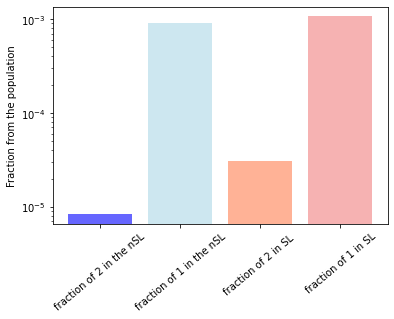

In [11]:
plt.bar(['fraction of 2 in the nSL','fraction of 1 in the nSL'],[index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)),index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns))],alpha=0.6,color=['blue','lightblue']), 

plt.bar(['fraction of 2 in SL ','fraction of 1 in SL'],[index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)),index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns))],alpha=0.6,color=['coral','lightcoral'])

plt.ylabel('Fraction from the population')
plt.yscale('log')
plt.xticks(rotation=40)

#### Adding the labels(response variables) to each dataset

In [12]:
protein_feat_true_pd['lethality']=np.ones(shape=(len(protein_a_list_new)))
protein_feat_non_true_pd['lethality']=np.zeros(shape=(len(protein_a_list_non_new)))

#### Joining both datasets

In [13]:
feature_post=pd.concat([protein_feat_true_pd,protein_feat_non_true_pd],axis=0)
feature_post=feature_post.set_index(np.arange(0,len(protein_a_list_new)+len(protein_a_list_non_new)))
print('The number of features are:',feature_post.shape[1])
print('The number of samples are:',feature_post.shape[0])

The number of features are: 3026
The number of samples are: 164


### Postprocessing and exploration of the feature matrix of both datasets

In [14]:
mean=feature_post.T.describe().loc['mean']
std=feature_post.T.describe().loc['std']
lethality=feature_post['lethality']

corr_keys=pd.concat([mean,std,lethality],axis=1)

### Viz of the stats

Text(0.5, 1.0, 'How the std varies with Lethality')

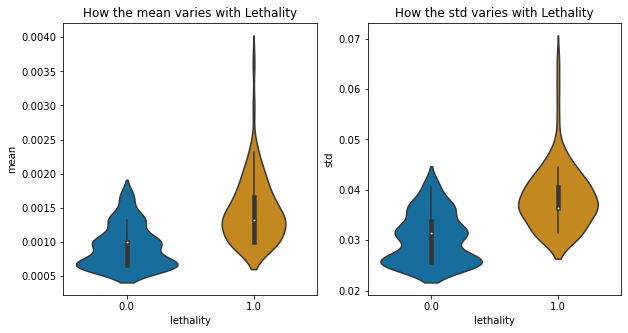

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
a=sns.violinplot(x="lethality", y="mean", data=corr_keys,ax=axs[0],palette='colorblind')
a.set_title('How the mean varies with Lethality')
b=sns.violinplot(x="lethality", y="std", data=corr_keys,ax=axs[1],palette='colorblind')
b.set_title('How the std varies with Lethality')
##plt.savefig('violinplot-mean-std-with-lethality.png', format='png',dpi=300,transparent='true')

Text(0.5, 1.08, 'Pairplot to see data dependencies with Lethality')

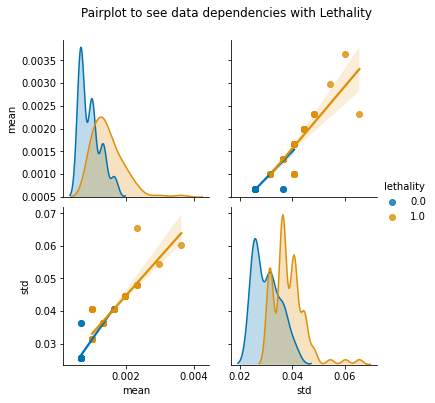

In [16]:
pair=sns.pairplot(corr_keys,hue='lethality',diag_kind='kde',kind='reg',palette='colorblind')
pair.fig.suptitle('Pairplot to see data dependencies with Lethality',y=1.08)
##plt.savefig('Pairplot-to-see-data-dependencies-with-Lethality.png',format='png',dpi=300,transparent='True', bbox_inches='tight')

In [17]:
a=scipy.stats.pearsonr(corr_keys['mean'],corr_keys['lethality'])
p_value_corr=defaultdict(dict)

columns=['mean','std']
for i in columns:
    
    tmp=scipy.stats.pearsonr(corr_keys[i],corr_keys['lethality'])
    p_value_corr[i]['corr with lethality']=tmp[0]
    p_value_corr[i]['p-value']=tmp[1]

p_value_corr_pd=pd.DataFrame(p_value_corr)

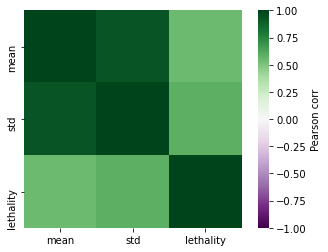

In [18]:
corr = corr_keys.corr()
import matplotlib.cm as cm
sns.heatmap(corr, vmax=1,vmin=-1 ,square=True,cmap=cm.PRGn,cbar_kws={'label':'Pearson corr'})
##plt.savefig('Heatmap-Pearson-corr-mean-std-lethality.png', format='png',dpi=300,transparent='true',bbox_inches='tight')

## Separate features from labels to set up the data from the ML workflow

In [19]:
X, y = feature_post.drop(columns=["lethality"]), feature_post["lethality"]

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.3, random_state= 0)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (114, 3025) (114,)
Test set: (50, 3025) (50,)


### Choosing the best SVM model

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
parameters = [{'C': [1, 10, 100], 'kernel': ['rbf'], 'gamma': ['auto','scale']}]
search = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.3s finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100], 'gamma': ['auto', 'scale'],
                          'kernel': ['rbf']}],
             verbose=1)

In [22]:
best_parameters = search.best_estimator_
print(best_parameters)

SVC(C=1)


### Training with the best model

#### Note : This learning is without applying reduction of dimensionality with PCA . This make the SVM not optimized at all. 
Later we shall see how this svm is affected after `PCA` transformation to the data .

In [23]:
from sklearn import svm

clf = svm.SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7

### Saving the model

In [24]:
from joblib import dump, load
dump(clf, '../model_SVC_C_10_gamma_scale_kernel_rbf_10000x3072_matrix.joblib') 

['../model_SVC_C_10_gamma_scale_kernel_rbf_10000x3072_matrix.joblib']

### Loading the model

In [25]:
from joblib import dump, load
clf = load('../model_SVC_C_10_gamma_scale_kernel_rbf_10000x3072_matrix.joblib') 

### Making predictions

In [26]:
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_score

y_pred = clf.predict(X_test)

# print('Train set Accuracy: ', metrics.accuracy_score(y_train, clf.predict(X_train)))
print('The mean squared error is =',metrics.mean_squared_error(y_test,y_pred))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('The Jaccard index is =', jaccard_score(y_test, y_pred))
# Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets. The closer to 1 the better the classifier 
print('The log-loss is =',log_loss(y_test,y_pred))
# how far each prediction is from the actual label, it is like a distance measure from the predicted to the actual , the classifer with lower log loss have better accuracy
print('The f1-score is =',metrics.f1_score(y_test,y_pred))
# The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

The mean squared error is = 0.3
Test set Accuracy:  0.7
The Jaccard index is = 0.5454545454545454
The log-loss is = 10.361808829907847
The f1-score is = 0.7058823529411765
Precision: 0.6206896551724138
Recall: 0.8181818181818182


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['NonSl','SL']))

              precision    recall  f1-score   support

       NonSl       0.81      0.61      0.69        28
          SL       0.62      0.82      0.71        22

    accuracy                           0.70        50
   macro avg       0.72      0.71      0.70        50
weighted avg       0.73      0.70      0.70        50



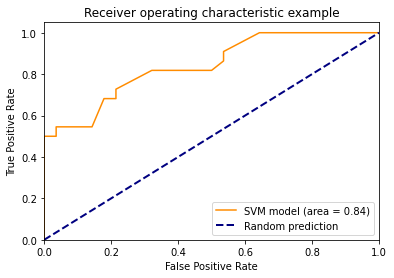

In [28]:
import sklearn.metrics as metrics
scores=clf.decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
area=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,color='darkorange',label='SVM model (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig('ROC-curve-SVC-on-classifing-lethality-using-PI-SL.png',format='png',dpi=300,transparent=False)

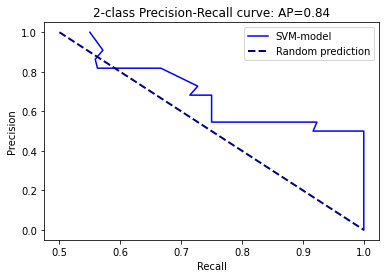

In [29]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, scores)
average_precision = metrics.average_precision_score(y_test, scores)
plt.plot(precision,recall,color='blue',label='SVM-model')

plt.plot([0.5, 1], [1, 0], color='navy', lw=2, linestyle='--',label='Random prediction')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.legend()

#plt.savefig('Precision-Recall-curve.png',format='png',dpi=300,transparent=False)

Text(0.5, 257.44, 'Predicted label')

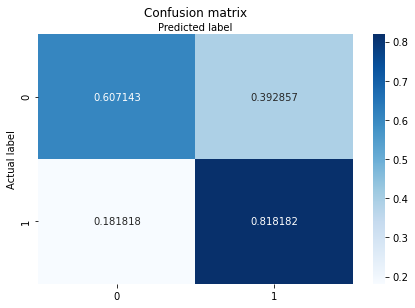

In [30]:
class_names=[1,2,3]
fig, ax = plt.subplots()
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

cm = confusion_matrix(y_test, y_pred,normalize="true")

class_names=['SL', 'nSL']

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#plt.savefig('confusion-matrix-normalized.png',format='png',dpi=300,transparent=False)

### Step of crossvalidation to evaluate the peformance of the classifier in terms of overfitting 

(**Caution!**) Highly time consuming ~2h for 10000 X 3072 matrix

In [31]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
import time

n_samples = X.shape[0]
t = time.process_time()
cv=StratifiedKFold(n_splits=5)
elapsed_time = time.process_time() - t
print('The elapsed time was',elapsed_time)

The elapsed time was 0.00019516499999916448


In [32]:
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

t = time.process_time()

cv_results = cross_validate(clf, X, y, cv=cv)
elapsed_time = time.process_time() - t
print('The elapsed time was',elapsed_time)

The elapsed time was 0.8487567399999989


In [33]:
#saving the results 
dump(cv_results, '../cross_val_object_5_fold_clf_model.joblib') 

['../cross_val_object_5_fold_clf_model.joblib']

In [34]:
from joblib import dump, load
#loading the crossvalidation 
cv=load('../cross_val_object_5_fold_clf_model.joblib') 

### Viz of the variation of the test error per fold . If the variation is high , the classifier may be proned to overfitting.

Text(0, 0.5, 'Accuracy')

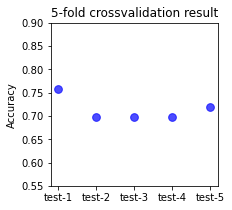

In [35]:
fig, axs = plt.subplots(ncols=1, figsize=(3,3))
sorted(cv_results.keys())

plt.scatter(['test-1','test-2','test-3','test-4','test-5'],cv_results['test_score'],s=60,alpha=0.7,color='blue')
plt.title('5-fold crossvalidation result')
plt.ylim(0.55,0.9)
plt.ylabel('Accuracy')
#plt.savefig('5-fold-crrosvalidation-result.png', format='png',dpi=300,transparent='true',bbox_inches='tight')

 ## Using PCA to reduce the dimensionality of the problem

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()


model_scaler = scaler.fit(X_train)
# Apply transform to both the training set and the test set.
x_train_S = model_scaler.transform(X_train)

x_test_S = model_scaler.transform(X_test)

# Fit PCA on training set. Note: you are fitting PCA on the training set only.
model = PCA(0.95).fit(x_train_S)

x_train_output_pca = model.transform(x_train_S)
x_test_output_pca = model.transform(x_test_S)

In [37]:
# np.shape(x_train_output_pca)
# np.shape(X_train.T)
np.shape(x_train_S),np.shape(x_test_S),model.components_.shape,np.shape(x_train_output_pca)

((114, 3025), (50, 3025), (95, 3025), (114, 95))

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
parameters = [{'C': [1, 10, 100], 'kernel': ['rbf'], 'gamma': ['auto','scale']}]
search = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=1)
search.fit(x_train_output_pca, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100], 'gamma': ['auto', 'scale'],
                          'kernel': ['rbf']}],
             verbose=1)

In [39]:
best_parameters = search.best_estimator_
print(best_parameters)

SVC(C=1)


In [40]:
from sklearn import svm

clf_after_pca = svm.SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(x_train_output_pca, y_train)
clf_after_pca.score(x_test_output_pca, y_test)

0.68

In [41]:
from joblib import dump, load

dump(clf_after_pca, '../model_SVC_C_10_gamma_scale_kernel_rbf_10000x1622_after_PCA_matrix.joblib') 

['../model_SVC_C_10_gamma_scale_kernel_rbf_10000x1622_after_PCA_matrix.joblib']

In [42]:
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_score

y_pred_after_pca = clf_after_pca.predict(x_test_output_pca)

# print('Train set Accuracy: ', metrics.accuracy_score(y_train, clf.predict(X_train)))
print('The mean squared error is =',metrics.mean_squared_error(y_test,y_pred_after_pca))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_pred_after_pca))
print('The Jaccard index is =', jaccard_score(y_test, y_pred_after_pca))
# Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets. The closer to 1 the better the classifier 
print('The log-loss is =',log_loss(y_test,y_pred_after_pca))
# how far each prediction is from the actual label, it is like a distance measure from the predicted to the actual , the classifer with lower log loss have better accuracy
print('The f1-score is =',metrics.f1_score(y_test,y_pred_after_pca))
# The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_after_pca))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_after_pca))

The mean squared error is = 0.32
Test set Accuracy:  0.68
The Jaccard index is = 0.36
The log-loss is = 11.052456422217228
The f1-score is = 0.5294117647058824
Precision: 0.75
Recall: 0.4090909090909091


Text(0.5, 257.44, 'Predicted label')

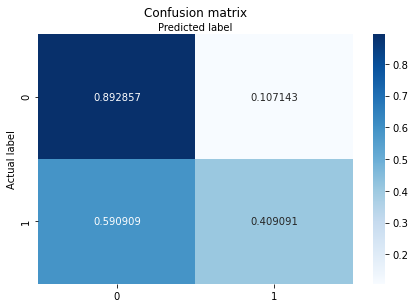

In [43]:
class_names=[1,2,3]
fig, ax = plt.subplots()
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

cm = confusion_matrix(y_test, y_pred_after_pca,normalize="true")

class_names=['SL', 'nSL']

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_after_pca, target_names=['NonSl','SL']))

              precision    recall  f1-score   support

       NonSl       0.66      0.89      0.76        28
          SL       0.75      0.41      0.53        22

    accuracy                           0.68        50
   macro avg       0.70      0.65      0.64        50
weighted avg       0.70      0.68      0.66        50

